In [ ]:
#Import Libraries
import io
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
#plt.style.use('fivethirtyeight')
plt.style.use('bmh')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving PFE_US_Equity.csv to PFE_US_Equity.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['PFE_US_Equity.csv']))

In [ ]:
df.shape

(1521, 3)

In [ ]:
df

,Date,PX_LAST,PX_VOLUME
0,5/1/2015,32.3061,21543362
1,5/4/2015,32.5336,23590434
2,5/5/2015,32.3440,22382158
3,5/6/2015,31.7184,26859481
4,5/7/2015,31.8321,21508469
...,...,...,...
1516,5/10/2021,39.8600,30831871
1517,5/11/2021,39.3500,30568572
1518,5/12/2021,39.6900,26208608
1519,5/13/2021,40.1000,25423778


In [ ]:
# convert the 'Date' column to datetime format
df['Date']= pd.to_datetime(df['Date']) 
#Reset "Date" as index
df.set_index("Date",inplace=True)
df

,PX_LAST,PX_VOLUME
Date,,
2015-05-01,32.3061,21543362
2015-05-04,32.5336,23590434
2015-05-05,32.3440,22382158
2015-05-06,31.7184,26859481
2015-05-07,31.8321,21508469
...,...,...
2021-05-10,39.8600,30831871
2021-05-11,39.3500,30568572
2021-05-12,39.6900,26208608


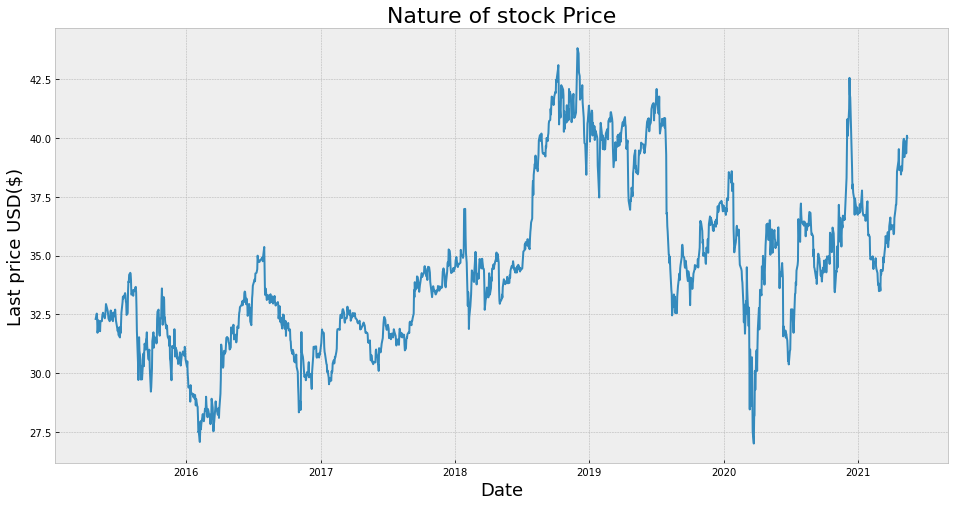

In [ ]:
#Visualizing closing price
plt.figure(figsize=(16,8))
plt.title('Nature of stock Price',fontsize=22)
plt.plot(df['PX_LAST'])
#plt.bar(df['PX_VOLUME'],df['PX_VOLUME'].values)
#plt.ylim((0,100))
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Last price USD($)',fontsize = 18)
#plt.savefig('Last price USD($).png')
plt.show()

In [ ]:
df['PX_LAST'].describe()

count    1521.000000
mean       34.466131
std         3.483577
min        27.007100
25%        31.879500
50%        34.059800
75%        36.391700
max        43.823700
Name: PX_LAST, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


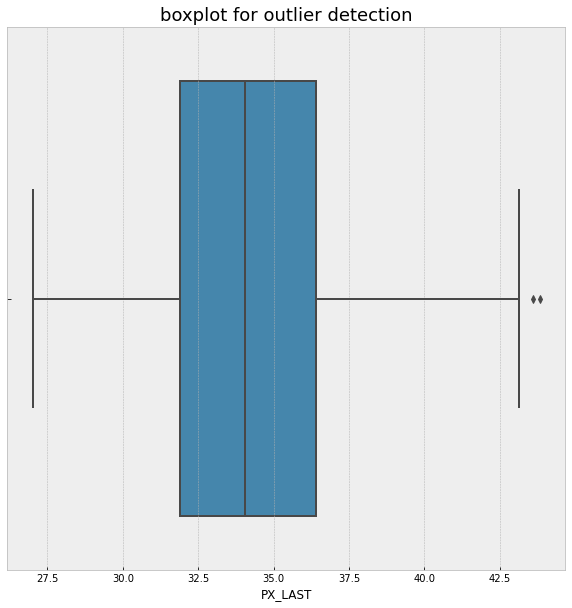

In [ ]:
#Closing price boxplot for outlier detection
plt.figure(figsize=(10,10))
plt.title("boxplot for outlier detection",fontsize=18)
sns.boxplot(df['PX_LAST'])

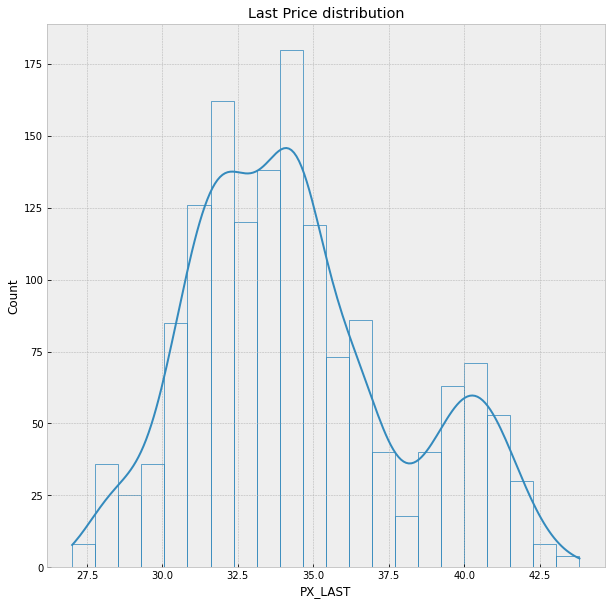

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Last Price distribution')
sns.histplot(df['PX_LAST'],kde=True,fill=False)

In [ ]:
#Create a new dataframe with only the "Close" column
data = df.filter(['PX_LAST'])
#Convert the dataframe to numpy array
dataset = data.values

In [ ]:
#Test for stationarity (ADF Test)
x = df['PX_LAST'].values
results = adfuller(x)
print("Test for stationarity (ADF Test)\n")
print('ADF Statistic: %f'%results[0])
print('p-value: %f'%results[1])
print('Critical Values:')
for key, value in results[4].items():
  print('\t%s: %.3f'%(key,value))

if results[0] < results[4]["5%"]:
  print("Reject Ho - Time Series is Stationary")
else:
  print("Failed to Reject Ho - Time Series in Non-Stationary")

Test for stationarity (ADF Test)

ADF Statistic: -2.470218
p-value: 0.122890
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Failed to Reject Ho - Time Series in Non-Stationary


In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()

In [ ]:
#For training data
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

1217

In [ ]:
scaled_data = scaler.fit_transform(dataset)

#Create the training data set
trained_data = scaled_data[0:training_data_len,:]
#Split data into X_train and y_train dataset
X_train = []
y_train = []

prediction_obs = 7

for i in range(prediction_obs,len(trained_data)):
  X_train.append(trained_data[i-prediction_obs:i,0])
  y_train.append(trained_data[i,0])
  # if i<= prediction_obs+1:
  #   print(X_train)
  #   print(y_train)
  #   print()

In [ ]:
#Convert data to array
X_train,y_train = np.array(X_train), np.array(y_train)

In [ ]:
#Reshape data
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1210, 7, 1)

In [ ]:
#Build the LSTM model:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
#Train model
model.fit(X_train,y_train,batch_size= 70,epochs= 200)

Epoch 1/200
18/18 [==============================] - 4s 11ms/step - loss: 0.1209
Epoch 2/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0163
Epoch 3/200
18/18 [==============================] - 0s 13ms/step - loss: 0.0120
Epoch 4/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0081
Epoch 5/200
18/18 [==============================] - 0s 12ms/step - loss: 0.0079
Epoch 6/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0068
Epoch 7/200
18/18 [==============================] - 0s 12ms/step - loss: 0.0066
Epoch 8/200
18/18 [==============================] - 0s 12ms/step - loss: 0.0072
Epoch 9/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 10/200
18/18 [==============================] - 0s 12ms/step - loss: 0.0065
Epoch 11/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 12/200
18/18 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 13/200
18/18 [=====

In [ ]:
#Create test dataset
#create new array contained scaled values from index 1217 to 1521
test_data = scaled_data[training_data_len-prediction_obs:,:]
test_data.shape

(311, 1)

In [ ]:
#create x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(prediction_obs,len(test_data)):
  x_test.append(test_data[i-prediction_obs:i,0])

In [ ]:
#Convert the data to numpy array
x_test = np.array(x_test)

In [ ]:
#Reshape the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
#Get the models prediction price values
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

In [ ]:
#Get Root Mean squared error (RMSE)
rmse = np.sqrt(np.mean(prediction-y_test)**2)
rmse

0.06626817496450317

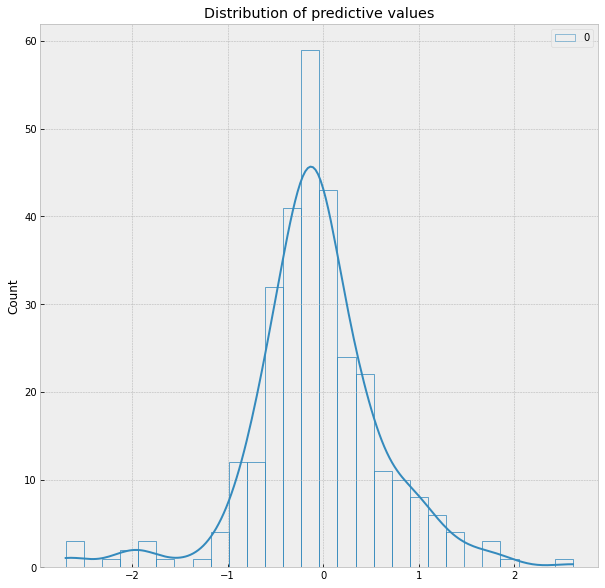

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Distribution of predictive values")
sns.histplot(y_test-prediction,kde=True,fill=False)

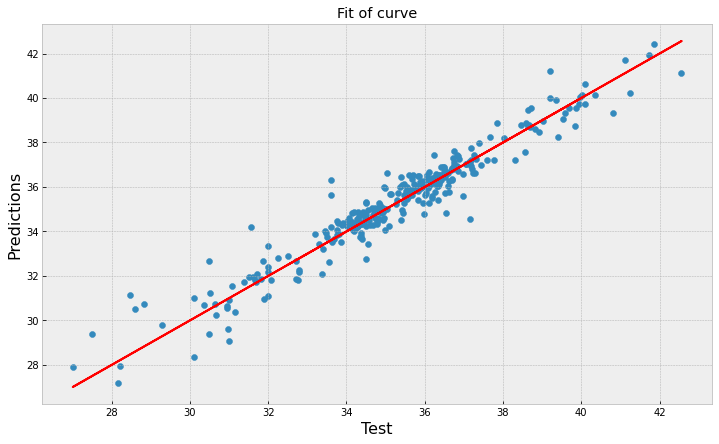

In [ ]:
plt.figure(figsize=(12,7))
plt.title('Fit of curve')
plt.scatter(y_test,prediction)
plt.ylabel('Predictions',fontsize=16)
plt.xlabel('Test',fontsize=16)
plt.plot(y_test,y_test,'r')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Unrecognized location 'Uppper left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if sys.path[0] == '':


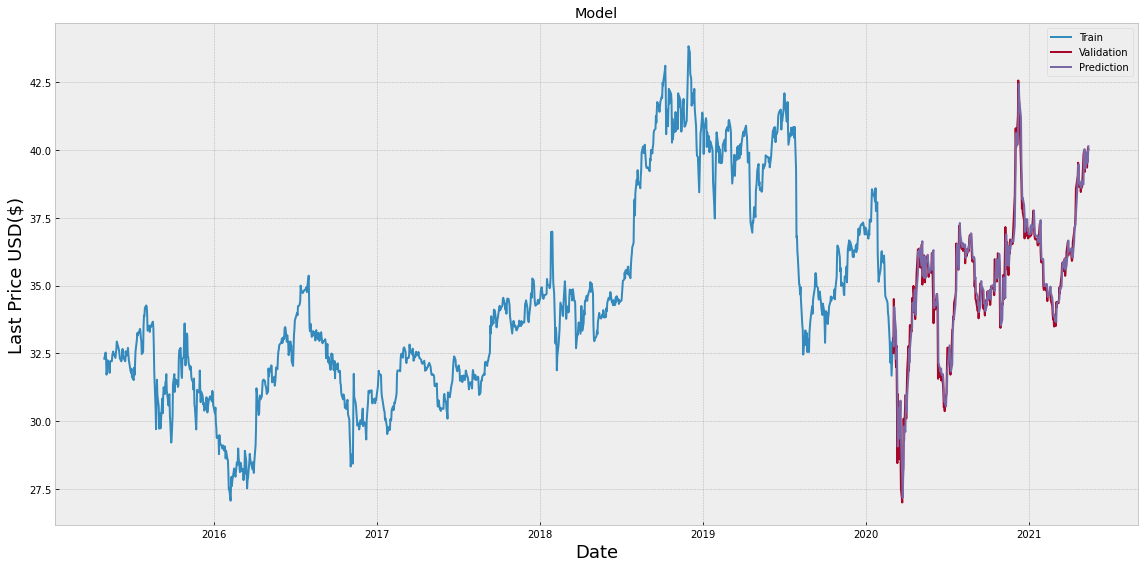

In [ ]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Prediction'] = prediction
#Visualization the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Last Price USD($)',fontsize=18)
plt.plot(train['PX_LAST'])
plt.plot(valid[['PX_LAST','Prediction']])
plt.legend(['Train','Validation','Prediction'],loc='Uppper left')
plt.tight_layout()

In [ ]:
#Show the actual and predicted price
valid

,PX_LAST,Prediction
Date,,
2020-03-03,32.5146,32.877579
2020-03-04,34.5053,32.759075
2020-03-05,33.6143,34.217144
2020-03-06,33.1972,33.901833
2020-03-09,32.0027,33.328110
...,...,...
2021-05-10,39.8600,39.558048
2021-05-11,39.3500,39.924683
2021-05-12,39.6900,39.536404


In [ ]:
from sklearn.metrics import explained_variance_score,mean_absolute_error
print("RSquared: ",explained_variance_score(y_test,prediction))
print("MAE: ",mean_absolute_error(y_test,prediction))

RSquared:  0.9264763513985118
MAE:  0.4767706033807051
